In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import cKDTree
import geopandas as gpd
import geopy.distance
from datetime import time

In [3]:
# Read All Datasets

# Real October month's Transit data
kingstonTransit = pd.read_excel('../data/Transit Data - October.xlsx')

# Read all the Bus Routes of Kingston Transit
allBusRoutes = gpd.read_file("../data/transit-gtfs-routes.geojson")

# Read all bustops serviced by Kingston Transit
allBusStops = gpd.read_file('../data/transit-gtfs-stops.geojson')
allBusStops.head()

# Read all Addresses
allDriveways = gpd.read_file('../data/civic-addresses.geojson')

# Read The City of Kingston map
kingstonMap = gpd.read_file("../data/landuse.shp")

In [3]:
# EDA - Remove invalid records from the list
allBusRoutes = allBusRoutes[allBusRoutes.route_id != "999"]
allBusRoutes.head()

,route_long_name,route_short_name,route_id,route_type,route_color,filename,geometry
0,None,7,7,Bus,8A6F45,gtfs,"MULTILINESTRING ((-76.47791 44.27481, -76.4781..."
1,None,14,14,Bus,C1CD23,gtfs,"MULTILINESTRING ((-76.57294 44.25507, -76.5727..."
2,None,16,16,Bus,B890C2,gtfs,"MULTILINESTRING ((-76.52310 44.26930, -76.5228..."
3,None,501,501,Bus,231F20,gtfs,"MULTILINESTRING ((-76.57215 44.25508, -76.5738..."
4,None,XTRA,XTRA,Bus,000000,gtfs,"MULTILINESTRING ((-76.51013 44.22445, -76.5127..."


In [4]:
# EDA - Cast datatype of Route and Bus column in the dataset
kingstonTransit['Route'] = kingstonTransit['Route'].astype('category')
kingstonTransit['Bus'] = kingstonTransit['Bus'].astype('category')
# Remove invalid records geocodes
kingstonTransit = kingstonTransit[(kingstonTransit['Latitude'] != 0) & (kingstonTransit['Longitude'] != 0)]
# check for empty/invalid records
kingstonTransit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648786 entries, 0 to 704538
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       648786 non-null  datetime64[ns]
 1   Time       648786 non-null  datetime64[ns]
 2   Class      648786 non-null  object        
 3   Operation  648786 non-null  object        
 4   Bus        648786 non-null  category      
 5   Route      648786 non-null  category      
 6   Latitude   648786 non-null  float64       
 7   Longitude  648786 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(2), object(2)
memory usage: 35.9+ MB


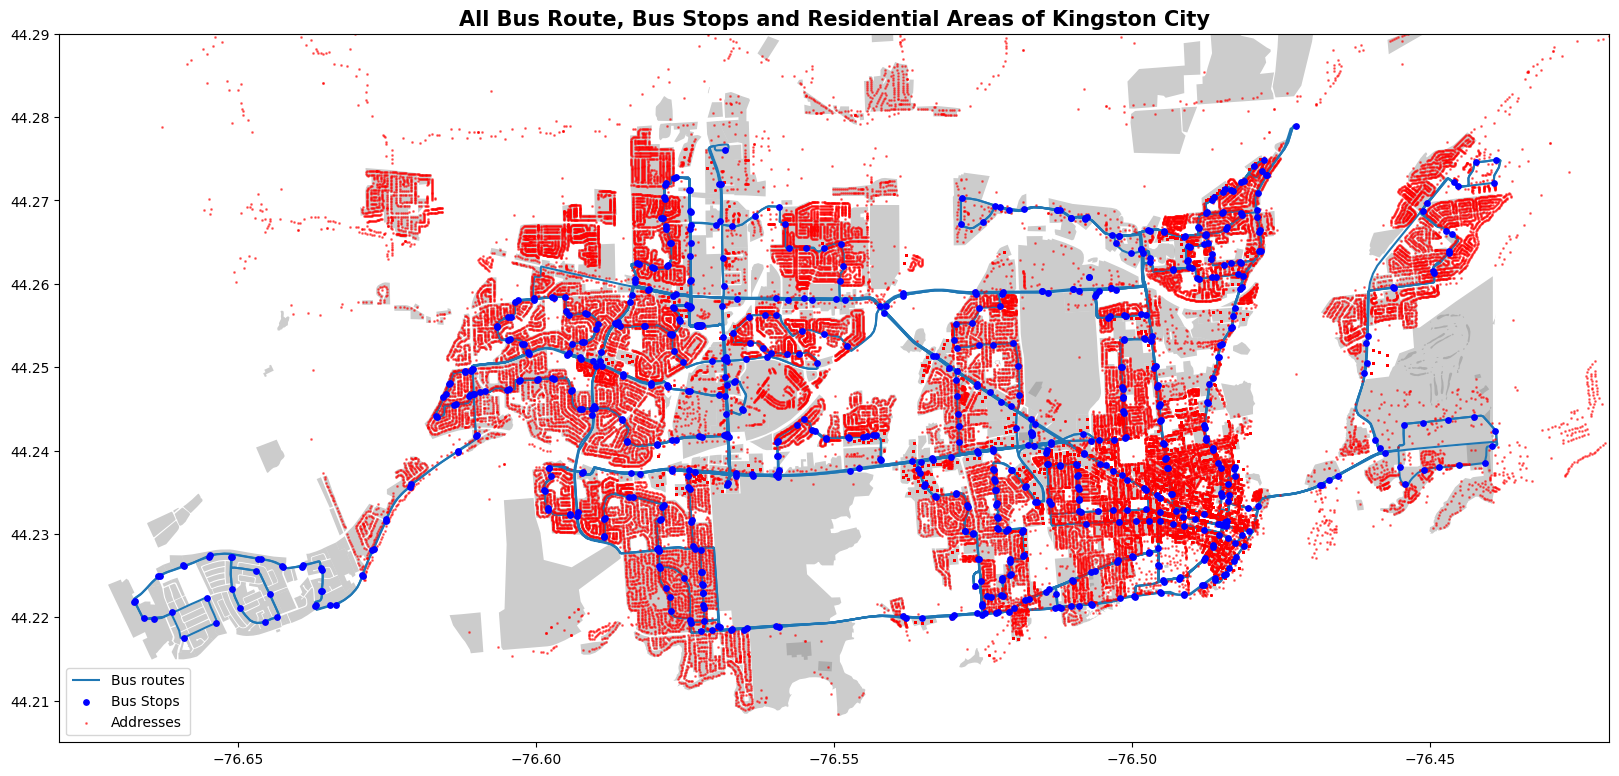

In [5]:
#  Using the same plot we used in Question 2
fig, ax = plt.subplots(figsize=(20,20))

# Plot the city of Kingston map
kingstonMap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)

# Plot bus routes
allBusRoutes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')

# Plot bus stops geodataframe to axes
allBusStops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')

# Plot all Driveways
allDriveways.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Addresses")


# Using officail limits of the city of Kingston
plt.xlim(-76.68,-76.420)
plt.ylim(44.205,44.29)
# Show map
plt.title("All Bus Route, Bus Stops and Residential Areas of Kingston City", fontsize=15, fontweight="bold")
ax.legend()
plt.show()

In [6]:
def getNearestBusStop(allDriveways, allBusStops):
  pA = np.array(list(allDriveways.geometry.apply(lambda x: (x.x, x.y))))
  pB = np.array(list(allBusStops.geometry.apply(lambda x: (x.x, x.y))))
  btree = cKDTree(pB)
  dist, idx = btree.query(pA, k=1)
  gdf = pd.concat([allDriveways.reset_index(drop=True), allBusStops.loc[idx, allBusStops.columns != 'geometry'].reset_index(drop=True), pd.Series(dist, name='dist')], axis=1)
  return gdf

In [7]:
# Calculate distance between addresses and the busstops
allDriveways['Latitude'] = allDriveways.geometry.y
allDriveways['Longitude'] = allDriveways.geometry.x

allBusStops['s_Latitude'] = allBusStops.geometry.y
allBusStops['s_Longitude'] = allBusStops.geometry.x

nearestBusStops = getNearestBusStop(allDriveways, allBusStops)
nearestBusStops.head()

,electoral_district_name,address_id,garbage_day,full_address,recycling_day,street_type_suffix,unit,address_number,street,direction_suffix,...,postal_code,geometry,Latitude,Longitude,stop_id,stop_name,wheelchair_boarding,s_Latitude,s_Longitude,dist
0,Pittsburgh,84935,Tuesday,1207 WATERSIDE WAY,Tuesday,WAY,None,1207,WATERSIDE WAY,None,...,None,POINT (-76.45446 44.27045),44.270452,-76.454460,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.003602
1,Pittsburgh,84940,Tuesday,1187 WATERSIDE WAY,Tuesday,WAY,None,1187,WATERSIDE WAY,None,...,K7K 0J1,POINT (-76.45392 44.27012),44.270124,-76.453916,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.002968
2,Pittsburgh,84958,Tuesday,741 HALLOWAY DR,Tuesday,DR,None,741,HALLOWAY DR,None,...,None,POINT (-76.45206 44.27174),44.271739,-76.452059,09234,Waterside Way (west side of Highway 15),0,44.26972,-76.45062,0.002479
3,Pittsburgh,84973,Tuesday,1453 SUMMER ST,Tuesday,ST,None,1453,SUMMER ST,None,...,<Null>,POINT (-76.45487 44.27112),44.271122,-76.454869,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.004294
4,Loyalist-Cataraqui,85125,Thursday,808 CELESTE DR,Thursday,DR,None,808,CELESTE DR,None,...,K7P 0P6,POINT (-76.54984 44.26798),44.267984,-76.549840,09075,Crossfield Avenue (west side of Andersen),0,44.26475,-76.54892,0.003363


In [8]:
# The above provies the direct path to the bustops which is not ture interms of walking to the bus top using a sidewalk
# so we will use geodesic to account for the same
def getDistanceToBusStop(data):
  coord1 = (data.Latitude, data.Longitude)
  coord2 = (data.s_Latitude, data.s_Longitude)
  return geopy.distance.geodesic(coord1, coord2).km

In [9]:
nearestBusStops['totalDistance'] = nearestBusStops.apply(lambda data: getDistanceToBusStop(data), axis=1)
nearestBusStops.describe()

,address_id,address_number,Latitude,Longitude,s_Latitude,s_Longitude,dist,totalDistance
count,69237.000000,69237.000000,69237.000000,69237.000000,69237.000000,69237.000000,69237.000000,69237.000000
mean,40871.188685,628.807690,44.250085,-76.522337,44.246805,-76.524743,0.007022,0.667581
std,25958.326214,732.691133,0.024452,0.056559,0.015049,0.047353,0.023491,2.173292
min,1.000000,1.000000,44.208423,-76.707282,44.218300,-76.663370,0.000055,0.005361
25%,19203.000000,108.000000,44.235043,-76.570495,44.234780,-76.568880,0.000899,0.084209
50%,38032.000000,381.000000,44.244103,-76.518982,44.243500,-76.519530,0.001524,0.146294
75%,59402.000000,901.000000,44.260528,-76.489689,44.258390,-76.487950,0.002716,0.261681
max,94759.000000,6796.000000,44.469750,-76.235006,44.278970,-76.439060,0.269932,26.277336


In [10]:
# Average distance to a bustop is  0.67 KM. 
nearestBusStops['totalDistance'].describe()

count    69237.000000
mean         0.667581
std          2.173292
min          0.005361
25%          0.084209
50%          0.146294
75%          0.261681
max         26.277336
Name: totalDistance, dtype: float64

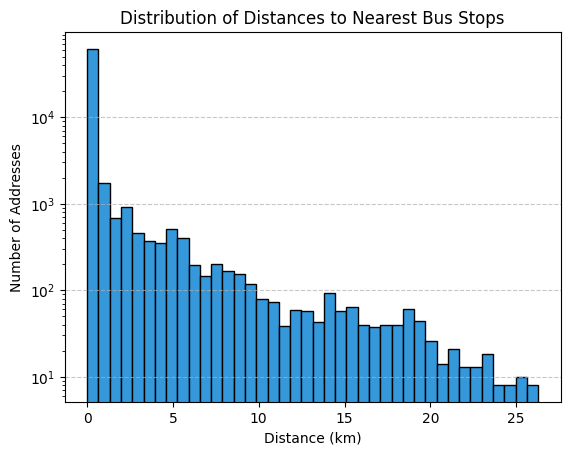

In [11]:
plt.hist(nearestBusStops['totalDistance'], log=True, bins=40, color='#3498db', edgecolor='black')
plt.xlabel("Distance (km)")
plt.ylabel("Number of Addresses")
plt.title("Distribution of Distances to Nearest Bus Stops")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [12]:
distances = nearestBusStops['totalDistance']

# Calculate IQR
Q1 = np.percentile(distances, 25)
Q3 = np.percentile(distances, 75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

upper_bound = round(upper_bound,2)

# Identify addresses significantly further away
farStops = nearestBusStops[nearestBusStops['totalDistance'] > upper_bound]
ids = farStops['address_id'].to_list()

# Print filter Value
print(f"Distance based on IQR: {upper_bound}")

# Print or further analyze 'far_addresses'
farStops.head()

Distance based on IQR: 1.15


,electoral_district_name,address_id,garbage_day,full_address,recycling_day,street_type_suffix,unit,address_number,street,direction_suffix,...,geometry,Latitude,Longitude,stop_id,stop_name,wheelchair_boarding,s_Latitude,s_Longitude,dist,totalDistance
12,Countryside,20483,Tuesday,1726 MARIAN CRES,Tuesday,CRES,None,1726,MARIAN CRES,None,...,POINT (-76.42667 44.29858),44.298577,-76.426666,00752,933 John Marks Avenue (north side),0,44.27489,-76.43906,0.026733,2.811810
37,Countryside,8589,Tuesday,2562 FINDLAY STATION RD,Tuesday,RD,None,2562,FINDLAY STATION RD,None,...,POINT (-76.27508 44.34074),44.340741,-76.275080,00752,933 John Marks Avenue (north side),0,44.27489,-76.43906,0.176708,14.991133
47,Loyalist-Cataraqui,76625,Friday,856 WINDERMERE DR,Friday,DR,None,856,WINDERMERE DR,None,...,POINT (-76.62771 44.27357),44.273569,-76.627705,00678,Humberside Drive (west side of Mona),0,44.25500,-76.60663,0.028089,2.662578
48,Loyalist-Cataraqui,76651,Friday,726 SQUIRREL HILL DR,Friday,DR,None,726,SQUIRREL HILL DR,None,...,POINT (-76.62609 44.27253),44.272535,-76.626093,00678,Humberside Drive (west side of Mona),0,44.25500,-76.60663,0.026197,2.492317
51,Countryside,77854,Thursday,500 MAPLE LAWN DR,Thursday,DR,None,500,MAPLE LAWN DR,None,...,POINT (-76.46064 44.30225),44.302250,-76.460644,Smspr1,Montreal Street Park and Ride,0,44.27897,-76.47257,0.026157,2.756380


In [13]:
# getting addresses that are >2KM from the nearest bus stop
farAddresses = allDriveways[allDriveways['address_id'].isin(ids)]
farAddresses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5794 entries, 12 to 69217
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   electoral_district_name  5783 non-null   object  
 1   address_id               5794 non-null   int64   
 2   garbage_day              5782 non-null   object  
 3   full_address             5794 non-null   object  
 4   recycling_day            5782 non-null   object  
 5   street_type_suffix       5794 non-null   object  
 6   unit                     106 non-null    object  
 7   address_number           5794 non-null   int64   
 8   street                   5794 non-null   object  
 9   direction_suffix         1 non-null      object  
 10  municipality             5794 non-null   object  
 11  street_body_name         5794 non-null   object  
 12  unit_type                5794 non-null   object  
 13  neighbourhood            5783 non-null   object  
 14

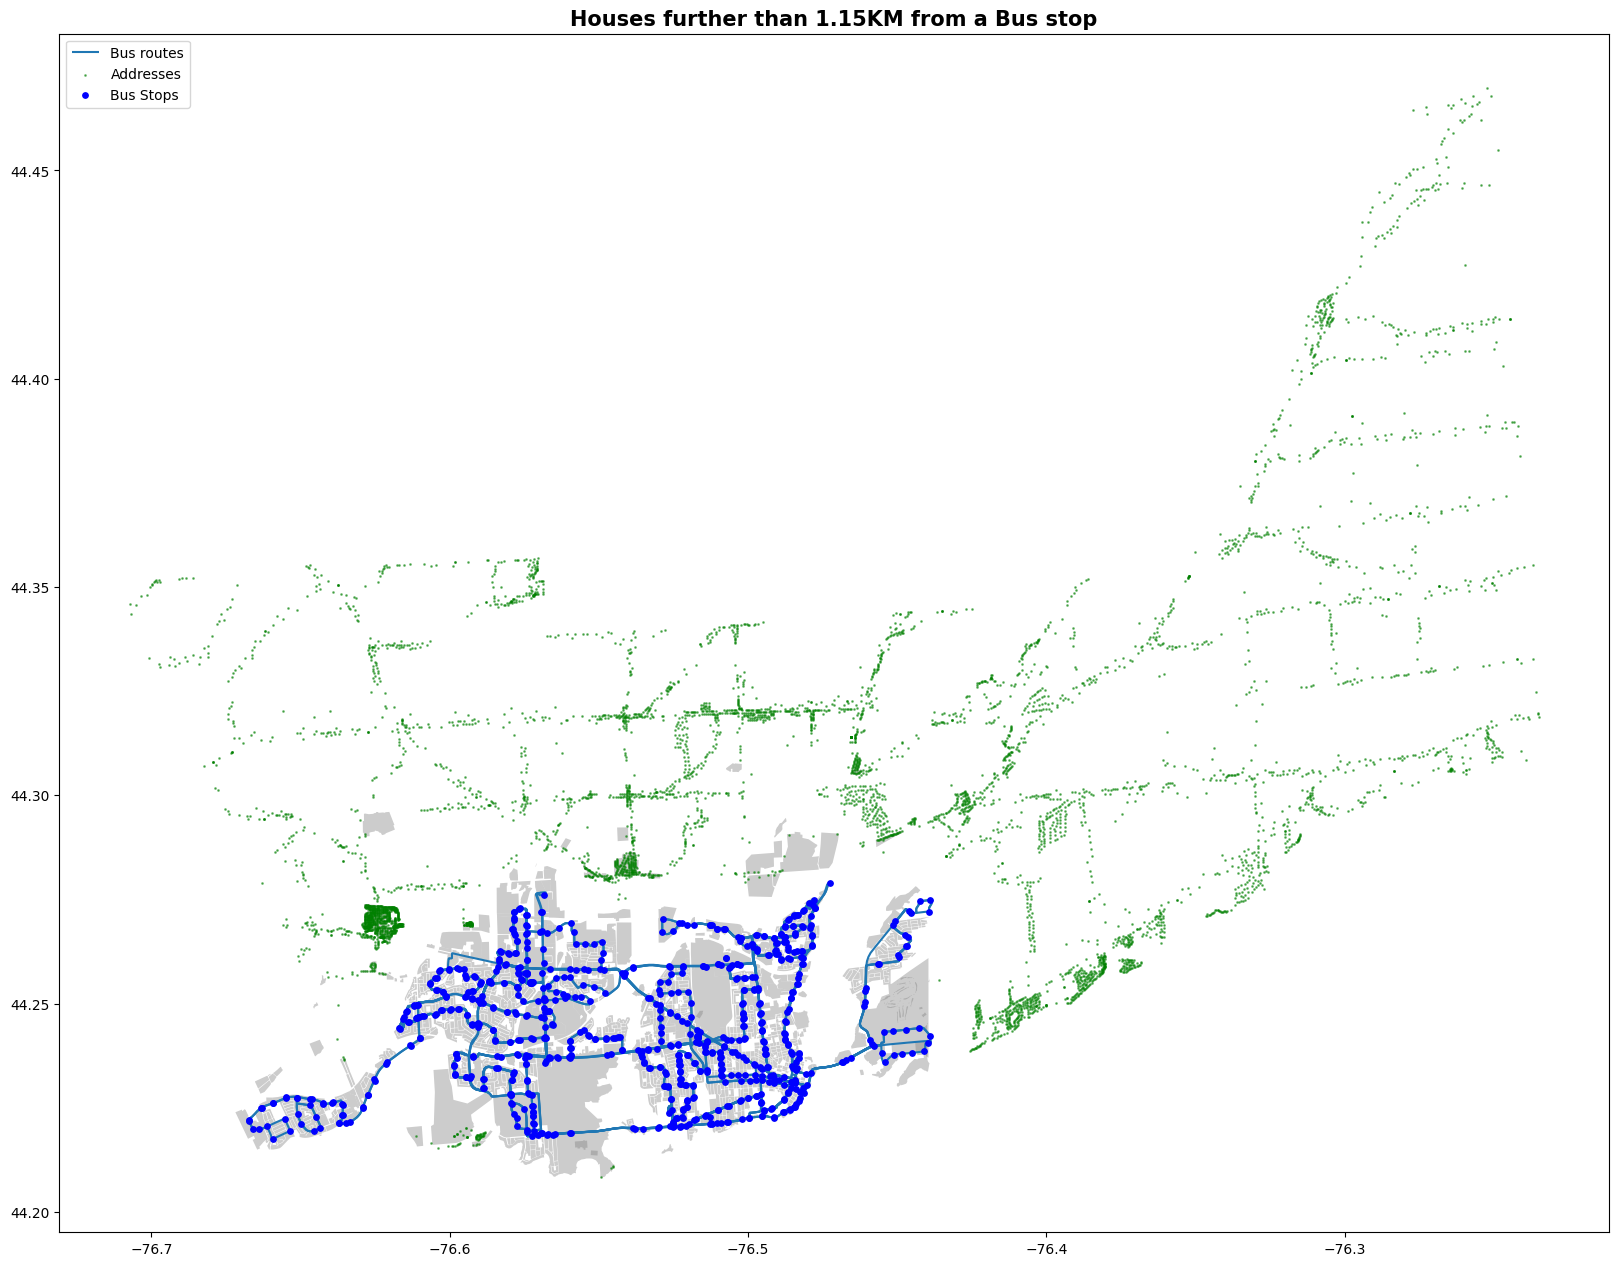

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
kingstonMap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add bus route shapefile
allBusRoutes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')
# Add addresses geodataframe to axes
farAddresses.plot(ax=ax, alpha=0.5, markersize=1, color="green", zorder=1, label="Addresses")
# Add bus stops geodataframe to axes
allBusStops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
# Show map
plt.title("Houses further than 1.15KM from a Bus stop", fontsize=15, fontweight="bold")
ax.legend()
plt.show()

In [15]:
# Get total number of houses in the list
totalHouses = farAddresses.shape[0]

# Get all stops
distinctStops = np.sort(farStops['stop_id'].unique())

# finding number of addresses that are 2km away from a bus stop and the bus stops ids
countHouses = farStops.groupby(['stop_id'])['address_id'].count()
countHouses

stop_id
00011        7
00026        4
00059        1
00069        1
00075       36
00089      435
00105        4
00145        3
00157        3
00210        5
00405       49
00530        3
00531      279
00533        1
00623      170
00645      189
00646        5
00667        5
00668        2
00669       40
00678      513
00726      461
00728        7
00752     1938
00758       56
00765        1
00790        3
00797       22
00814      177
00827        1
00828       91
00829       16
00850       40
02013        4
02019       18
09061        6
09075       57
09081       50
09102       12
09239       71
S00028       6
S00033       1
S00523       3
S00712     326
S00818      23
S02080       6
Smspr1     643
Name: address_id, dtype: int64

In [16]:
# we will take stops that accomodate more than 150 addresses that are more than 2KM away
allStopsOverUpperBound = distinctStops[countHouses > 300]


# get addresses that correspond to stops that accomodate more than 150 addresses that are more than 2KM away
denseAddresses = nearestBusStops[(nearestBusStops['stop_id'].isin(allStopsOverUpperBound))]
denseAddresses = denseAddresses[denseAddresses['totalDistance'] > 2]
denseAddresses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3803 entries, 12 to 69165
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   electoral_district_name  3795 non-null   object  
 1   address_id               3803 non-null   int64   
 2   garbage_day              3794 non-null   object  
 3   full_address             3803 non-null   object  
 4   recycling_day            3794 non-null   object  
 5   street_type_suffix       3803 non-null   object  
 6   unit                     87 non-null     object  
 7   address_number           3803 non-null   int64   
 8   street                   3803 non-null   object  
 9   direction_suffix         0 non-null      object  
 10  municipality             3803 non-null   object  
 11  street_body_name         3803 non-null   object  
 12  unit_type                3803 non-null   object  
 13  neighbourhood            3795 non-null   object  
 14

In [17]:
filterStops = allBusStops[allBusStops['stop_id'].isin(allStopsOverUpperBound)]

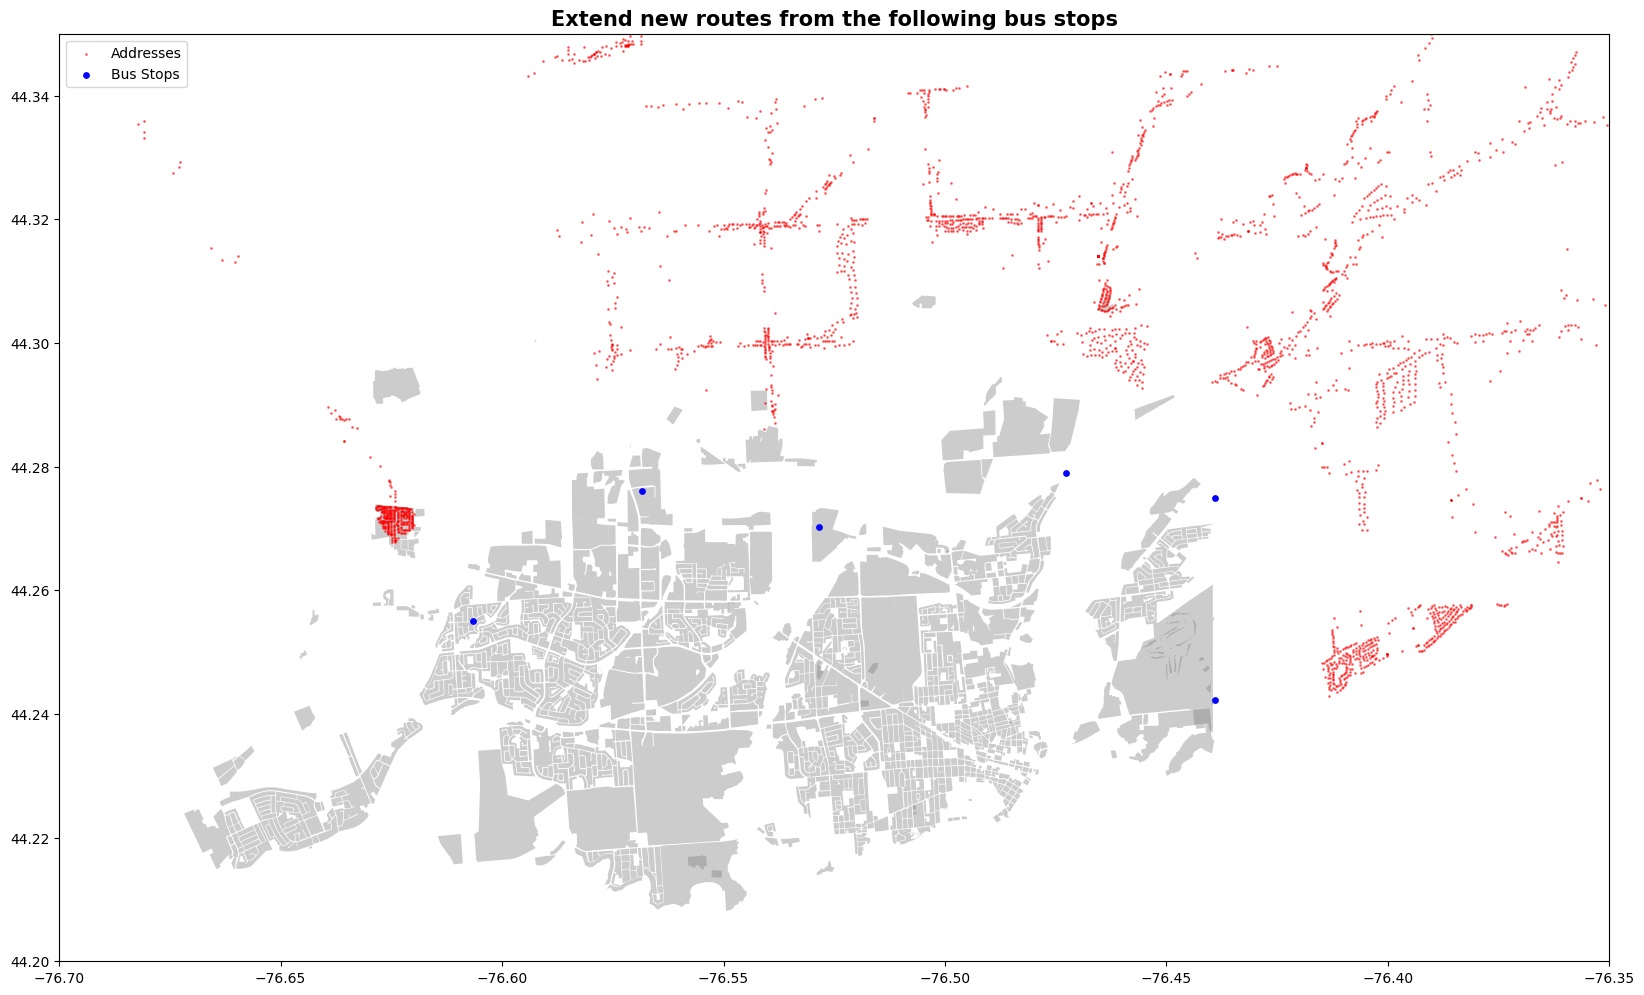

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
kingstonMap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add addresses geodataframe to axes
denseAddresses.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Addresses")
# Add bus stops geodataframe to axes
filterStops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
# Show map
plt.title("Extend new routes from the following bus stops", fontsize=15, fontweight="bold")
plt.xlim(-76.7,-76.35)
plt.ylim(44.2,44.35)
ax.legend()
plt.show()